In [100]:
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [101]:
train_features = np.load('C:\\Users\\atr\\Desktop\\save\\single\\caltech\\caltech_train_features.npy')
train_labels = np.load('C:\\Users\\atr\\Desktop\\save\\single\\caltech\\caltech_train_labels.npy')
train_features = np.squeeze(train_features)
print("train_features.shape:",train_features.shape)
print("train_labels.shape", train_labels.shape)

test_features = np.load('C:\\Users\\atr\\Desktop\\save\\single\\caltech\\caltech_test_features.npy')
test_labels = np.load('C:\\Users\\atr\\Desktop\\save\\single\\caltech\\caltech_test_labels.npy')
test_features = np.squeeze(test_features)
print("test_features.shape:",test_features.shape)
print("test_labels.shape", test_labels.shape)

train_features.shape: (4380, 84)
train_labels.shape (4380, 1)
test_features.shape: (1022, 84)
test_labels.shape (1022, 1)


In [102]:
from sklearn import svm
classifier = svm.SVC(gamma = 150)
classifier.fit(train_features, train_labels)
classifier.score(test_features,test_labels)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6741682974559687

In [103]:
#使用pca降维
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
pca_train = pca.fit_transform(train_features)
pca_test = pca.fit_transform(test_features)
print("new_train.shape:", pca_train.shape)
print("new_test.shape:", pca_test.shape)

new_train.shape: (4380, 60)
new_test.shape: (1022, 60)


In [104]:
from sklearn import svm
classifier = svm.SVC(gamma=60)
classifier.fit(pca_train, train_labels)
classifier.score(pca_test,test_labels)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5733855185909981

In [105]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso           # 此处以L1正则化的线性模型Lasso为例
lasso = Lasso(alpha=0.0005).fit(train_features, train_labels) 
model = SelectFromModel(lasso, prefit=True)

train_new = model.transform(train_features)
test_new = model.transform(test_features)

print("train_new.shape:", train_new.shape)
print("test_new.shape:", test_new.shape)

train_new.shape: (4380, 11)
test_new.shape: (1022, 11)


D:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4874725341796875, tolerance: 0.10949999839067459
  positive)


In [106]:
from sklearn import svm
classifier = svm.SVC(gamma=300)
classifier.fit(train_new, train_labels)
classifier.score(test_new,test_labels)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.62426614481409

In [108]:
addfeatures_train = []
addfeatures_test = []

for i in range(30):
    min_train = train_features[i*146:(i+1)*146]
    addfeatures_train.append(min_train)
    
for i in range(7):
    min_test = test_features[i*146:(i+1)*146]
    addfeatures_test.append(min_test)
    
addfeatures_train = np.squeeze(np.array(addfeatures_train))
addfeatures_train = addfeatures_train.transpose(0,2,1)
addfeatures_test = np.squeeze(np.array(addfeatures_test))
addfeatures_test = addfeatures_test.transpose(0,2,1)
    
addtrain_labels = np.array([0]*15+[1]*15)
addtest_labels = np.array([0]*4+[1]*3)

In [109]:
addfeatures_train.shape

(30, 84, 146)

In [110]:
from nilearn.connectome import ConnectivityMeasure
from nilearn.connectome import sym_matrix_to_vec

conn_est = ConnectivityMeasure(kind = 'tangent')
addfeatures_train = conn_est.fit_transform(addfeatures_train)
print(addfeatures_train.shape)
addfeatures_train = sym_matrix_to_vec(addfeatures_train)

addfeatures_test = conn_est.fit_transform(addfeatures_test)
addfeatures_test = sym_matrix_to_vec(addfeatures_test)

(30, 146, 146)


In [97]:
addfeatures_train.shape

(30, 10731)

In [98]:
from sklearn import svm
classifier = svm.LinearSVC()
classifier.fit(addfeatures_train, addtrain_labels)
classifier.score(addfeatures_test,addtest_labels)

0.7142857142857143

In [99]:
def fisherscore(data, labels, num):

    high = len(data)  # 向量个数
    weight = len(data[0])  # 向量长度
    P_num = np.sum(labels == 0)  # 正样本
    N_num = np.sum(labels == 1)  # 负样本

    # 计算Fisher score

    fisherscore = []
    for i in range(weight):
        p = []
        n = []
        p_var = []
        n_var = []
        for j in range(high):
            if labels[j] == 0:
                p.append(data[j, i])
            if labels[j] == 1:
                n.append(data[j, i])

        p_average = np.sum(p) / len(p)
        n_average = np.sum(n) / len(n)
        average = (np.sum(p) + np.sum(n)) / (len(p) + len(n))

        for j in range(high):
            if labels[j] == 0:
                p_var.append((data[j, i] - p_average) ** 2)
            if labels[j] == 1:
                n_var.append((data[j, i] - n_average) ** 2)

        score = ((p_average - average) ** 2 + (n_average - average) ** 2) / (
                    np.sum(p_var) / len(p) + np.sum(n_var) / len(n))

        fisherscore.append(score)

    index = np.argsort(-np.array(fisherscore))  # 返回索引
    new_data = []
    for i in range(num):
        new_data.append(data[:, index[i]])

    new_data = np.array(new_data)
    new_data = new_data.transpose(1, 0)

    return new_data

In [82]:
fisher_train = fisherscore(addfeatures_train, addtrain_labels, 2)
fisher_test = fisherscore(addfeatures_test, addtest_labels, 2)

In [83]:
from sklearn import svm
classifier = svm.SVC(kernel = 'linear')
classifier.fit(fisher_train, addtrain_labels)
classifier.score(fisher_test,addtest_labels)

0.2857142857142857

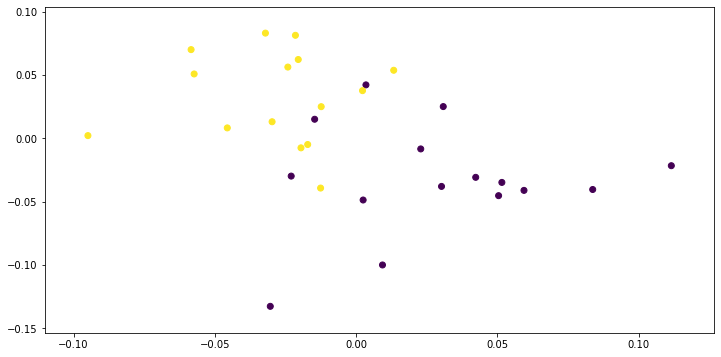

In [84]:
plt.figure(figsize=(12, 6))
plt.scatter(fisher_train[:, 0], fisher_train[:, 1], c=addtrain_labels)

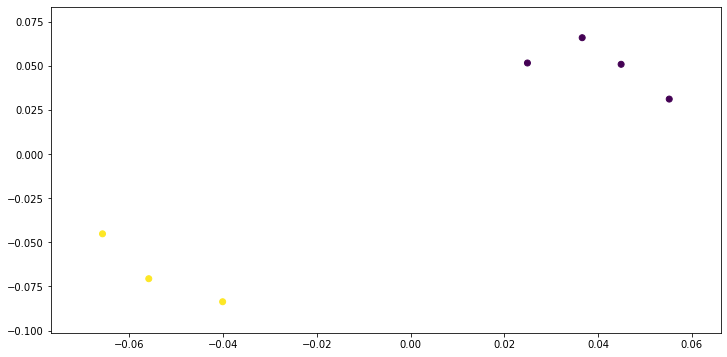

In [85]:
plt.figure(figsize=(12, 6))
plt.scatter(fisher_test[:, 0], fisher_test[:, 1], c=addtest_labels)